In [80]:
import utils
import log_parser
import pandas as pd
import random
import re
from numpy import NaN
from numpy import mean


In [81]:
import zss
import sexpdata

def sexp_size(sexp):
  if isinstance(sexp, list):
    return sum(sexp_size(child) for child in sexp)
  else:
    return 1

def sexp_to_tree(sexp):
  if isinstance(sexp, list):
    tree = zss.Node(sexp[0])
    for i in range(1, len(sexp)):
      tree.addkid(sexp_to_tree(sexp[i]))
    return tree
  else:
    return zss.Node(sexp)

def ted_distance(s1, s2):
  return zss.distance(sexp_to_tree(sexpdata.loads(s1)), sexp_to_tree(sexpdata.loads(s2)), zss.Node.get_children, insert_cost, remove_cost, update_cost1)
  return zss.simple_distance(sexp_to_tree(s1), sexp_to_tree(s2), zss.Node.get_children, zss.Node.get_label, my_label_distance)

def insert_cost(n):
  return depth(n)

def remove_cost(n):
  return depth(n)

def update_cost1(n1, n2):
  return my_label_distance(zss.Node.get_label(n1), zss.Node.get_label(n2)) + abs(depth(n1) - depth(n2))

def update_cost2(n1, n2):
  children1 = zss.Node.get_children(n1)
  children2 = zss.Node.get_children(n2)
  if not children1:
    return depth(n2)
  if not children2:
    return depth(n1)
  dist = my_label_distance(zss.Node.get_label(n1), zss.Node.get_label(n2))
  if len(children1) > len(children2):
    small = children2
    big = children1
  else:
    small = children1
    big = children2
  for i in range(len(small)):
    dist += update_cost2(big[i], small[i])
  for i in range(len(small), len(big)):
    dist += insert_cost(big[i])
  return dist


def my_label_distance(l1, l2):
  if l1 == l2:
    return 0
  else:
    return 1

def depth(tree : zss.Node):
  if not zss.Node.get_children(tree):
    return 1
  else:
    return 1 + max(depth(child) for child in zss.Node.get_children(tree))

In [82]:
def ted(t1, t2):
  return ted_distance(t1, t2)

def sed(s1, s2):
  import editdistance
  return editdistance.eval(s1, s2)

def get_thereorem_body(s):
  if match := re.match(f'(Lemma|Theorem) (\w+)[ ]?:(?P<body>.+)', s):
    return match.groupdict()["body"].strip()
  else:
    return s

def get_goal(s):
  if match := re.match(f'(.*)(forall|exists) (.+),(?P<goal>[\w\W]+)', s):
    return match.groupdict()["goal"].strip()
  else:
    return s

In [83]:
import pandas as pd
df = pd.read_pickle('./data.pickle')

In [84]:
frames = []
for filename in df["file"].unique():
  frames.append(df[df["file"] == filename])
  print(filename)

smallclam_lf_goal21_theorem0_49_append_assoc
smallclam_lf_goal7_theorem0_58_plus_comm
smallclam_lf_goal18_theorem0_41_append_assoc
smallclam_lf_goal79_theorem0_43_append_assoc
smallclam_lf_goal33_mult_succ_82_plus_assoc
smallclam_lf_goal34_plus_qmult_66_plus_commut
smallclam_lf_goal32_rotate_len_append_51_append_assoc
smallclam_lf_goal83_theorem0_50_append_assoc
smallclam_lf_goal7_theorem0_54_plus_comm
smallclam_lf_goal17_theorem0_40_lem
smallclam_lf_goal33_mult_succ_81_plus_assoc


In [85]:
def random_rank(frames):
  first_rank = [[] for i in range(len(frames))]
  mean_rank = [[] for i in range(len(frames))]
  for index in range(len(frames)):
    for iter in range(100):
      for i, _ in frames[index].iterrows():
        frames[index].loc[i, 'alpha'] = random.uniform(0,1)    
      all_equiv = []
      sorted_frame = frames[index].sort_values('alpha', ascending=False, ignore_index=True)
      for i, row in sorted_frame.iterrows():
        if row['is_equiv']:
          all_equiv.append(i)
      if not all_equiv:
        all_equiv.append(NaN)
      first_rank[index].append(all_equiv[0])
      mean_rank[index].append(mean(all_equiv))
  return [mean(first_rank[i]) for i in range(len(frames))], [mean(mean_rank[i]) for i in range(len(frames))]

In [86]:
first_ranks, mean_ranks = random_rank(frames)

In [6]:
random_rank(frames)

([nan, 29.42, 53.85, 26.2, nan, 22.99, 51.57, 5.35, 5.99, 24.11, 6.99],
 [nan,
  93.33166666666666,
  74.91,
  39.11,
  nan,
  57.33,
  76.315,
  22.95166666666666,
  23.196666666666665,
  58.6925,
  24.578333333333333])

In [88]:
def smallest_first(frames):
  first_rank = [[] for i in range(len(frames))]
  mean_rank = [[] for i in range(len(frames))]
  for index in range(len(frames)):
    for i, _ in frames[index].iterrows():
      frames[index].loc[i, "lemma_len"] = len(frames[index].loc[i, "lemma"])
    all_equiv = []
    sorted_frame = frames[index].sort_values('lemma_len', ascending=True, ignore_index=True)
    for i, row in sorted_frame.iterrows():
      if row["is_equiv"]:
        all_equiv.append(i)
    if not all_equiv:
      all_equiv.append(NaN)
    first_rank[index].append(all_equiv[0])
    mean_rank[index].append(mean(all_equiv))
  return [mean(first_rank[i]) for i in range(len(frames))], [mean(mean_rank[i]) for i in range(len(frames))]

In [31]:
first_ranks, avg_ranks = smallest_first(frames)

In [89]:
def tree_edit_distance(frames):
  first_rank = [[] for i in range(len(frames))]
  mean_rank = [[] for i in range(len(frames))]
  for index in range(len(frames)):
    for i, _ in frames[index].iterrows():
      frames[index].loc[i, "ted"] = len(frames[index].loc[i, "lemma"])
    all_equiv = []
    sorted_frame = frames[index].sort_values('ted', ascending=True, ignore_index=True)
    for i, row in sorted_frame.iterrows():
      if row["is_equiv"]:
        all_equiv.append(i)
    if not all_equiv:
      all_equiv.append(NaN)
    first_rank[index].append(all_equiv[0])
    mean_rank[index].append(mean(all_equiv))
  return [mean(first_rank[i]) for i in range(len(frames))], [mean(mean_rank[i]) for i in range(len(frames))]

In [92]:
for frame in frames:
  frame["ugly_lemma_len"] = frame["ugly_lemma_lemma"]

/tmp/ipykernel_9020/190079094.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame["ugly_lemma_len"] = frame["ugly_lemma_lemma"]
/tmp/ipykernel_9020/190079094.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame["ugly_lemma_len"] = frame["ugly_lemma_lemma"]
/tmp/ipykernel_9020/190079094.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

In [93]:
import coq_serapy

def use_lemma(lemma_name):
  return f'rewrite {lemma_name} || rewrite <- {lemma_name} || apply {lemma_name}.'

def use_helper_lemma_then_IH(prelude, before_helper_cmds, helper_lemma, stmts=[]):
    if isinstance(prelude, str):
        prelude = [s.strip() + '.' for s in prelude.strip().split(".")[:-1]]
    with coq_serapy.SerapiContext(
            ["sertop", "--implicit"],    
            None,
            "/home/yousef/lemmaranker/benchmark/smallclam") as coq:
        for stmt in prelude:
            coq.run_stmt(stmt.strip('-'))
        for stmt in stmts:
            coq.run_stmt(stmt)
        try:
            cmds_left, cmds_run = coq.run_into_next_proof(
            before_helper_cmds)
            for cmd in cmds_left:
                coq.run_stmt(cmd)
            try:
                coq.run_stmt(use_lemma(helper_lemma))
                ind_hyps = []
                for hyp in coq.proof_context.fg_goals[0].hypotheses:
                    match = re.match('(?P<name>IH\w*)[ ]?:',hyp)
                    if match:
                        ind_hyps.append(match.groups()[0])
                if ind_hyps:
                    use_ind_hyps_cmd = ' || '.join(use_lemma(hyp)[:-1] for hyp in ind_hyps) + '|| fail.'
                    try:
                        coq.run_stmt(use_ind_hyps_cmd)
                        return True, True
                    except:
                        return True, False
            except:
                return False, False
        except coq_serapy.CoqExn:
            return False, False
        except Exception as e:
            return False, False


In [94]:

def lemma_enables_IH(row):
  try:
    prelude = row["prelude"]
    lemma = row["lemma"]
    lemma_name = row["lemma_name"]
    theorem_stmt = row["theorem"]
    theorem_proof = [cmd.strip() + '.' for cmd in row["theorem_proof"].replace('-', ' ').replace('+', ' ').split('.') if cmd]
    lfind_idx = theorem_proof.index('lfind.')
    before_lfind_cmds, after_lfind_cmds = theorem_proof[:lfind_idx], theorem_proof[lfind_idx+1:]
    stmts = [lemma, 'Admitted.']
    used_IH_before = any('IH' in cmd for cmd in before_lfind_cmds)
    proof_cmds = [theorem_stmt] + before_lfind_cmds # + ['rewrite IHx | rewrite IHy | rewrite <- IHx | rewrite <- IHy | apply IHx | apply IHy | fail.', 'Admitted.'] + after_lfind_cmds
    return use_helper_lemma_then_IH(prelude, proof_cmds, lemma_name, stmts)[1]
  except:
    return False

In [95]:
def enables_IH(frames):
  first_rank = [[] for i in range(len(frames))]
  mean_rank = [[] for i in range(len(frames))]
  for index in range(len(frames)):
    # for i, row in frames[index].iterrows():
    #   frames[index].loc[i, "enables_IH"] = lemma_enables_IH(row)
    all_equiv = []
    sorted_frame = frames[index].sort_values(['enables_IH', 'alpha'], ascending=True, ignore_index=True)
    for i, row in sorted_frame.iterrows():
      if row["is_equiv"]:
        all_equiv.append(i)
    if not all_equiv:
      all_equiv.append(NaN)
    first_rank[index].append(all_equiv[0])
    mean_rank[index].append(mean(all_equiv))
  return [mean(first_rank[i]) for i in range(len(frames))], [mean(mean_rank[i]) for i in range(len(frames))]

In [19]:
enables_IH(frames)

/tmp/ipykernel_16013/2703890258.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames[index].loc[i, "enables_IH"] = lemma_enables_IH(row)
/tmp/ipykernel_16013/2703890258.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames[index].loc[i, "enables_IH"] = lemma_enables_IH(row)
/tmp/ipykernel_16013/2703890258.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [136]:
import matplotlib.pyplot as plt
import numpy as np
from torch import alpha_dropout, norm
def visualize_ranks(label, frames, first_ranks, avg_ranks, normalize=True):
  ordered_frames = sorted(frames, key=lambda frame: frame.file[0])
  denom = [len(frame) if normalize else 1 for frame in ordered_frames]
  data = [
    [first_ranks[i]*100/denom[i] for i in range(len(ordered_frames))],
    [avg_ranks[i]*100/denom[i] for i in range(len(ordered_frames))],
    [len(frame) for frame in ordered_frames]]
  X = np.arange(len(ordered_frames))
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  ax.set_xticks(80 * np.arange(len(ordered_frames)), [frame.at[0, 'file'][13:] for frame in ordered_frames])
  ax.bar(80 * X + -10, data[0], color = 'b', width = 20)
  ax.bar(80 * X + 10, data[1], color = 'g', width = 20)
  if normalize:
    ax.bar(80 * X, 100, color = 'gray', alpha=0.15, width=40)
  else:
    ax.bar(80 * X + 0, data[2], color = 'gray', alpha=0.15, width = 40)
  ax.legend(['First', 'Mean', 'Total'])
  if normalize:
    label += '(Normalized)'
  ax.set_title(label)
  fig.autofmt_xdate()
  fig.set_dpi(100)

def visualize_rank_difference(label, frames, first_ranks1, avg_ranks1, first_ranks2, avg_ranks2, normalize=True):
  ordered_frames = sorted(frames, key=lambda frame: frame.file[0])
  denom = [len(frame) if normalize else 1 for frame in ordered_frames]
  data = [
    [(first_ranks1[i] - first_ranks2[i])*100/denom[i] for i in range(len(ordered_frames))],
    [(avg_ranks1[i] - avg_ranks2[i])*100/denom[i] for i in range(len(ordered_frames))],
    [len(frame) for frame in ordered_frames]
  ]
  X = np.arange(len(ordered_frames))
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  ax.set_xticks(80 * np.arange(len(ordered_frames)), [frame.at[0, 'file'][13:] for frame in ordered_frames])

  ax.bar(80 * X + -10, data[0], color = 'b', width = 20)
  ax.bar(80 * X + 10, data[1], color = 'g', width = 20)
  ax.legend(['First', 'Mean', 'Total'])
  if normalize:
    label += '(Normalized)'
  ax.set_title(label)
  yabs_max = abs(max(ax.get_ylim(), key=abs))
  ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)
  fig.autofmt_xdate()
  fig.set_dpi(100)



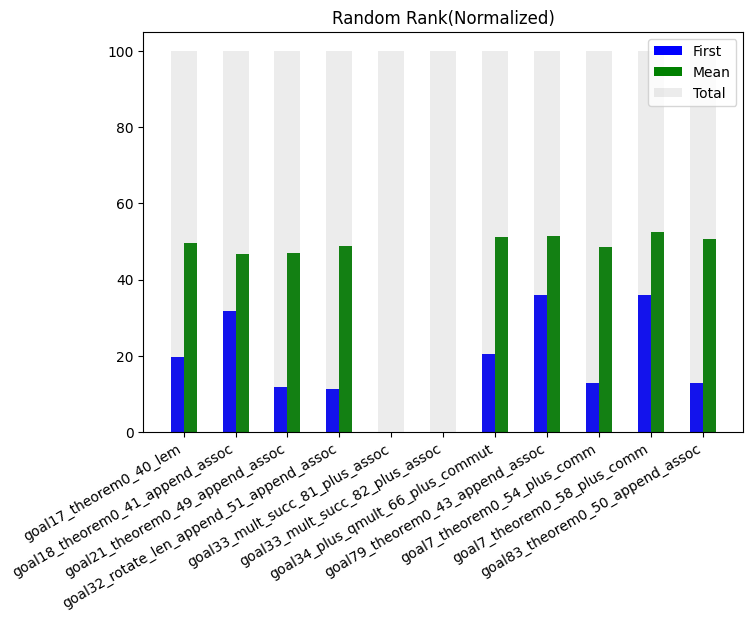

In [144]:
rand_first_ranks, rand_avg_ranks = random_rank(frames)
visualize_ranks("Random Rank", frames, rand_first_ranks, rand_avg_ranks)

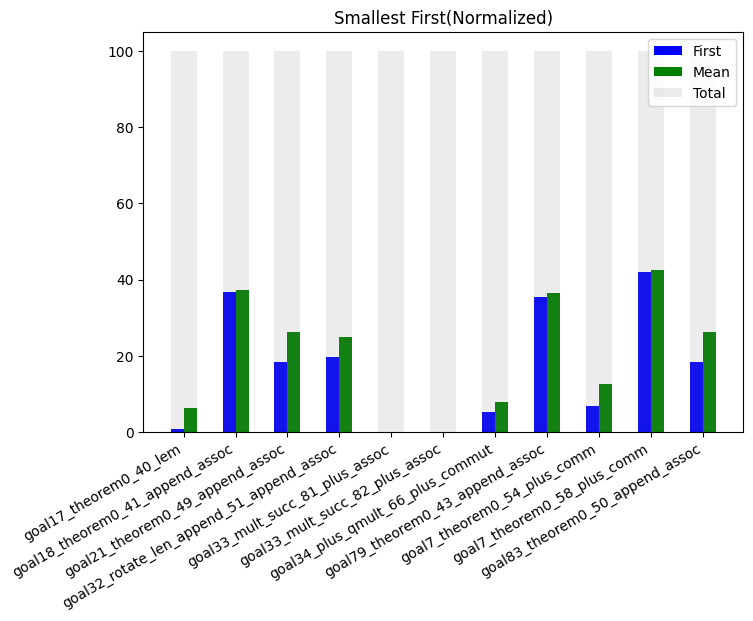

In [143]:
small_first_ranks, small_avg_ranks = smallest_first(frames)
visualize_ranks("Smallest First", frames, small_first_ranks, small_avg_ranks)

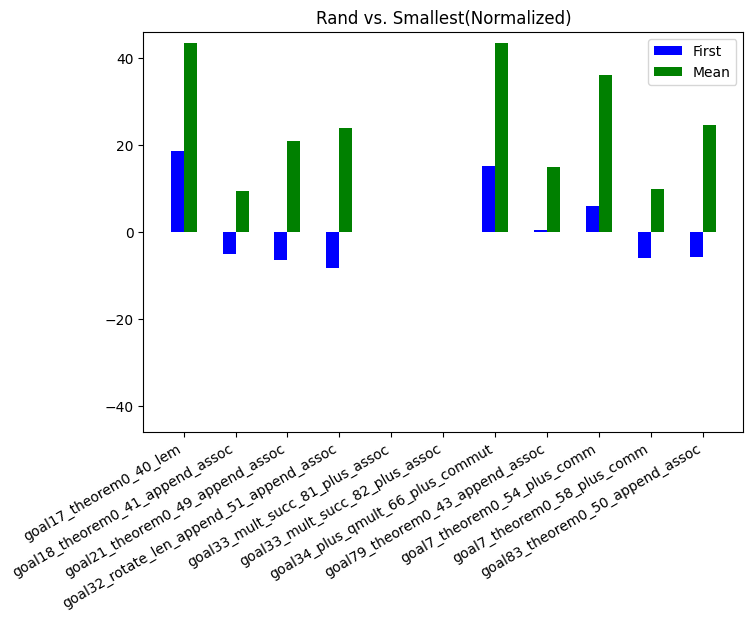

In [145]:
visualize_rank_difference("Rand vs. Smallest", frames, rand_first_ranks, rand_avg_ranks, small_first_ranks, small_avg_ranks, normalize=True)

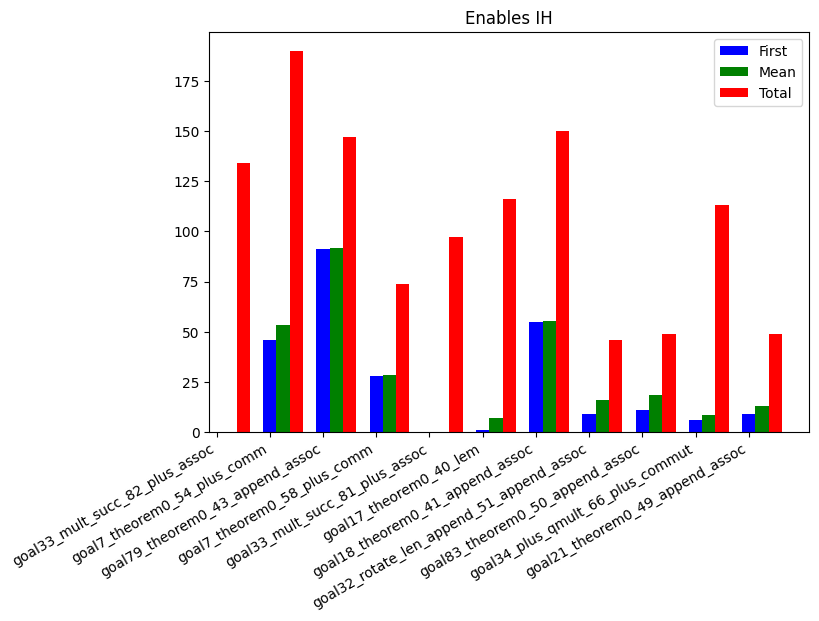

In [17]:
enable_IH_first_rank, enable_IH_avg_rank = enables_IH(frames)
visualize_ranks("Enables IH", frames, enable_IH_first_rank, enable_IH_avg_rank)

In [ ]:
for idx in range(len(frames)):
  print(len(frames[idx][frames[idx]["enables_IH"] == True]), len(frames[idx]))

0 134
155 190
67 147
0 74
0 97
0 116
0 150
20 46
20 49
113 113
0 49


In [ ]:
def cat2_first(frames):
  first_rank = [[] for i in range(len(frames))]
  mean_rank = [[] for i in range(len(frames))]
  for index in range(len(frames)):
    for i, _ in frames[index].iterrows():
      frames[index].loc[i, "lemma_len"] = len(frames[index].loc[i, "lemma"])
    all_equiv = []
    sorted_frame = frames[index].sort_values(['cat', 'lemma_len'], ascending=True, ignore_index=True)
    for i, row in sorted_frame.iterrows():
      if row["is_equiv"]:
        all_equiv.append(i)
    if not all_equiv:
      all_equiv.append(NaN)
    first_rank[index].append(all_equiv[0])
    mean_rank[index].append(mean(all_equiv))
  return [mean(first_rank[i]) for i in range(len(frames))], [mean(mean_rank[i]) for i in range(len(frames))]

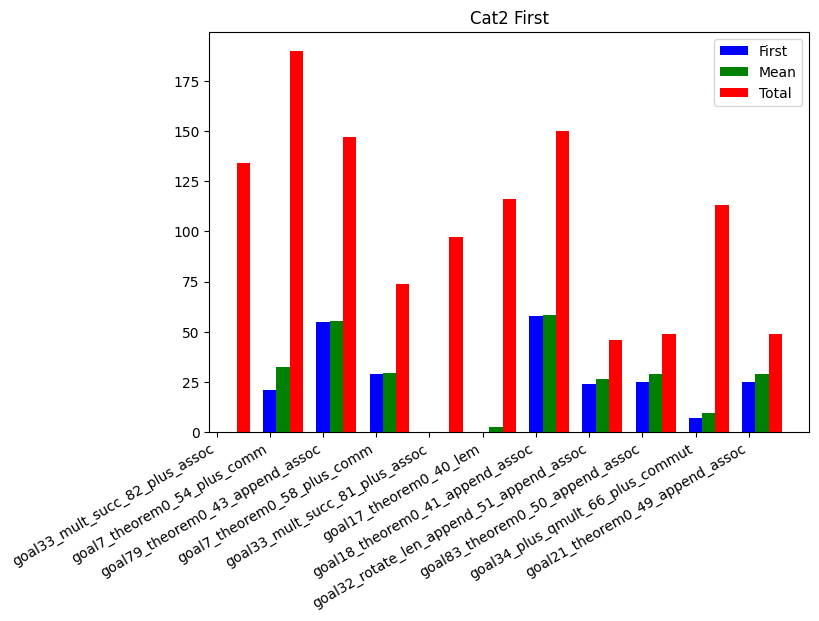

In [ ]:
cat2_first_ranks, cat2_avg_ranks = cat2_first(frames)
visualize_ranks("Cat2 First", frames, cat2_first_ranks, cat2_avg_ranks)

In [94]:
import coq_serapy

def disable_notations(prelude, theorem):
    if isinstance(prelude, str):
        prelude = [s.strip() + '.' for s in prelude.strip().split(".")[:-1]]
    with coq_serapy.SerapiContext(
            ["sertop", "--implicit"],
            None,
            "/home/yousef/lemmaranker/benchmark/smallclam") as coq:
        for stmt in prelude:
            coq.run_stmt(stmt.strip('-'))
        coq.run_stmt('Unset Printing Notations.')
        coq.run_stmt(theorem)
        return coq.goals

In [95]:
disable_notations(frames[0].at[0, "prelude"], frames[0].at[0, "theorem"])

'forall x y : natural, @eq natural (plus (mult x y) x) (mult x (Succ y))'

In [114]:
def order_by_sed(frames):
  first_rank = [[] for i in range(len(frames))]
  mean_rank = [[] for i in range(len(frames))]
  for index in range(len(frames)):
    for i, _ in frames[index].iterrows():
      frames[index].loc[i, "sed"] = sed(get_goal(frames[index].loc[i, 'ugly_theorem']), get_goal(frames[index].loc[i, 'ugly_lemma']))
    all_equiv = []
    sorted_frame = frames[index].sort_values(['sed', 'lemma_len'], ascending=True, ignore_index=True)
    for i, row in sorted_frame.iterrows():
      if row["is_equiv"]:
        all_equiv.append(i)
    if not all_equiv:
      all_equiv.append(NaN)
    first_rank[index].append(all_equiv[0])
    mean_rank[index].append(mean(all_equiv))
  return [mean(first_rank[i]) for i in range(len(frames))], [mean(mean_rank[i]) for i in range(len(frames))]

def order_by_ted(frames):
  first_rank = [[] for i in range(len(frames))]
  mean_rank = [[] for i in range(len(frames))]
  for index in range(len(frames)):
    for i, _ in frames[index].iterrows():
      # frames[index].loc[i, "sexp_lemma"] = sexpdata.loads(f"({get_goal(frames[index].loc[i, 'ugly_lemma'])})")
      frames[index].loc[i, "sexp_lemma_size"] = sexp_size(sexpdata.loads(f"({get_goal(frames[index].loc[i, 'ugly_lemma'])})"))
      frames[index].loc[i, "ted"] = ted(f"({get_goal(frames[index].loc[i, 'ugly_theorem'])})", f"({get_goal(frames[index].loc[i, 'ugly_lemma'])})")
    all_equiv = []
    sorted_frame = frames[index].sort_values(['ted', 'sexp_lemma_size'], ascending=True, ignore_index=True)
    for i, row in sorted_frame.iterrows():
      if row["is_equiv"]:
        all_equiv.append(i)
    if not all_equiv:
      all_equiv.append(NaN)
    first_rank[index].append(all_equiv[0])
    mean_rank[index].append(mean(all_equiv))
  return [mean(first_rank[i]) for i in range(len(frames))], [mean(mean_rank[i]) for i in range(len(frames))]

In [115]:
sed_first_ranks = order_by_sed(frames)
ted_first_ranks = order_by_ted(frames)

/tmp/ipykernel_9020/3113902737.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames[index].loc[i, "sed"] = sed(get_goal(frames[index].loc[i, 'ugly_theorem']), get_goal(frames[index].loc[i, 'ugly_lemma']))
/tmp/ipykernel_9020/3113902737.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames[index].loc[i, "sed"] = sed(get_goal(frames[index].loc[i, 'ugly_theorem']), get_goal(frames[index].loc[i, 'ugly_lemma']))
/tmp/ipykernel_9020/3113902737.py:6: SettingWithCopyWarning: 
A value is trying to be set 

In [66]:
sexp_size(sexpdata.loads(f"({frames[0].at[0, 'ugly_lemma']})"))

20

In [103]:
def smallest_first(frames):
  first_rank = [[] for i in range(len(frames))]
  mean_rank = [[] for i in range(len(frames))]
  for index in range(len(frames)):
    all_equiv = []
    sorted_frame = frames[index].sort_values('lemma_len', ascending=True, ignore_index=True)
    for i, row in sorted_frame.iterrows():
      if row["is_equiv"]:
        all_equiv.append(i)
    if not all_equiv:
      all_equiv.append(NaN)
    first_rank[index].append(all_equiv[0])
    mean_rank[index].append(mean(all_equiv))
  return [mean(first_rank[i]) for i in range(len(frames))], [mean(mean_rank[i]) for i in range(len(frames))]

def smallest_ugly_first(frames):
  first_rank = [[] for i in range(len(frames))]
  mean_rank = [[] for i in range(len(frames))]
  for index in range(len(frames)):
    all_equiv = []
    sorted_frame = frames[index].sort_values('ugly_lemma_len', ascending=True, ignore_index=True)
    for i, row in sorted_frame.iterrows():
      if row["is_equiv"]:
        all_equiv.append(i)
    if not all_equiv:
      all_equiv.append(NaN)
    first_rank[index].append(all_equiv[0])
    mean_rank[index].append(mean(all_equiv))
  return [mean(first_rank[i]) for i in range(len(frames))], [mean(mean_rank[i]) for i in range(len(frames))]

def smallest_sexp_first(frames):
  first_rank = [[] for i in range(len(frames))]
  mean_rank = [[] for i in range(len(frames))]
  for index in range(len(frames)):
    all_equiv = []
    sorted_frame = frames[index].sort_values('sexp_lemma_size', ascending=True, ignore_index=True)
    for i, row in sorted_frame.iterrows():
      if row["is_equiv"]:
        all_equiv.append(i)
    if not all_equiv:
      all_equiv.append(NaN)
    first_rank[index].append(all_equiv[0])
    mean_rank[index].append(mean(all_equiv))
  return [mean(first_rank[i]) for i in range(len(frames))], [mean(mean_rank[i]) for i in range(len(frames))]

In [149]:
f1, a1 = smallest_first(frames)
f2, a2 = smallest_ugly_first(frames)
f3, a3 = smallest_sexp_first(frames)

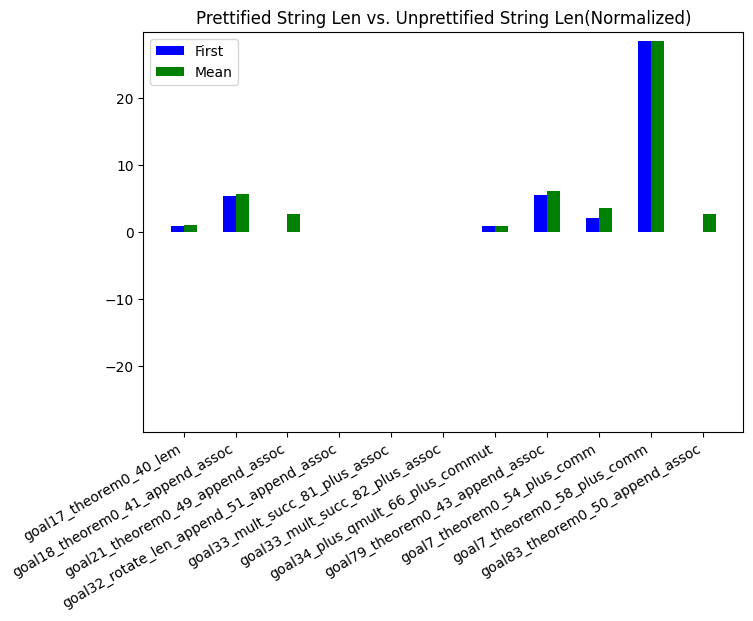

In [156]:
visualize_rank_difference("Prettified String Len vs. Unprettified String Len", frames, f1, a1, f2, a2)

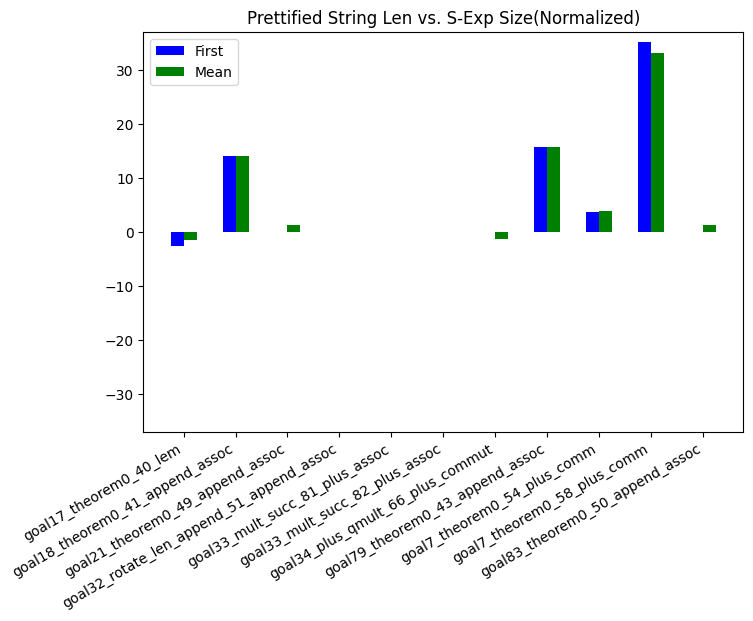

In [157]:
visualize_rank_difference("Prettified String Len vs. S-Exp Size", frames, f1, a1, f3, a3)


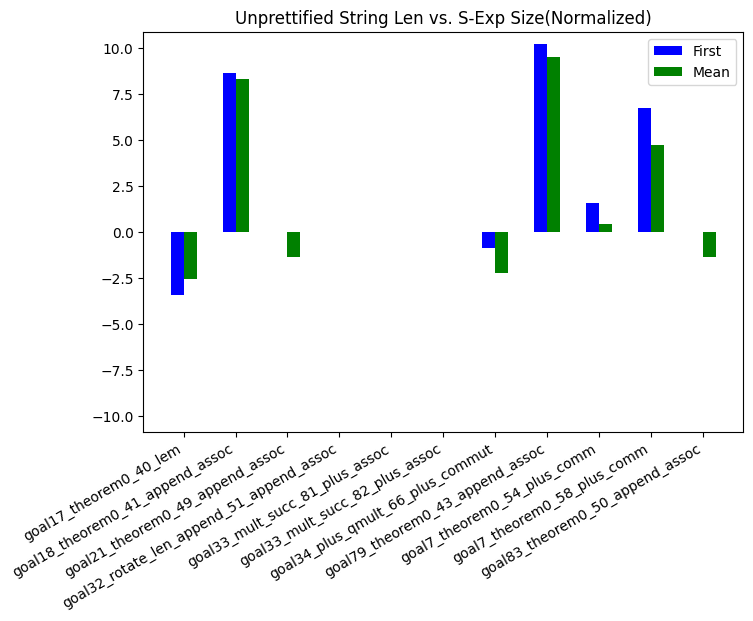

In [158]:
visualize_rank_difference("Unprettified String Len vs. S-Exp Size", frames, f2, a2, f3, a3)


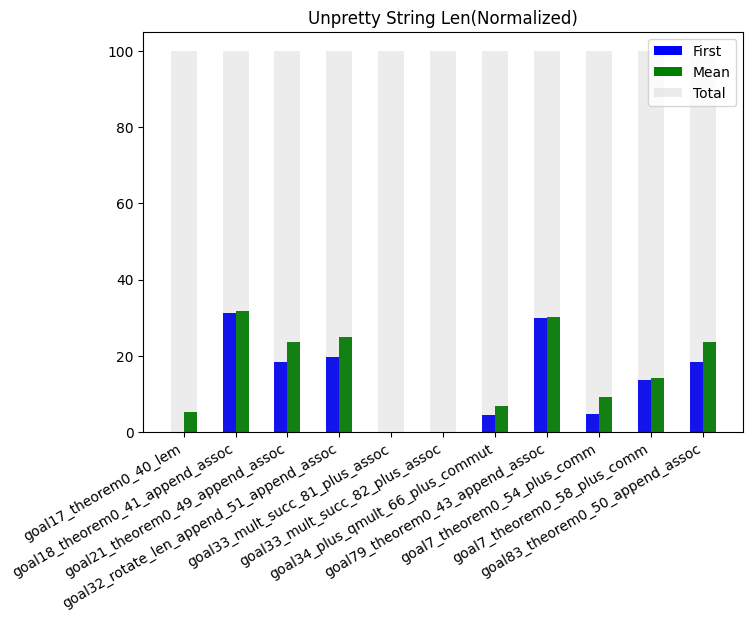

In [154]:
visualize_ranks("Unpretty String Len", frames, f2, a2)

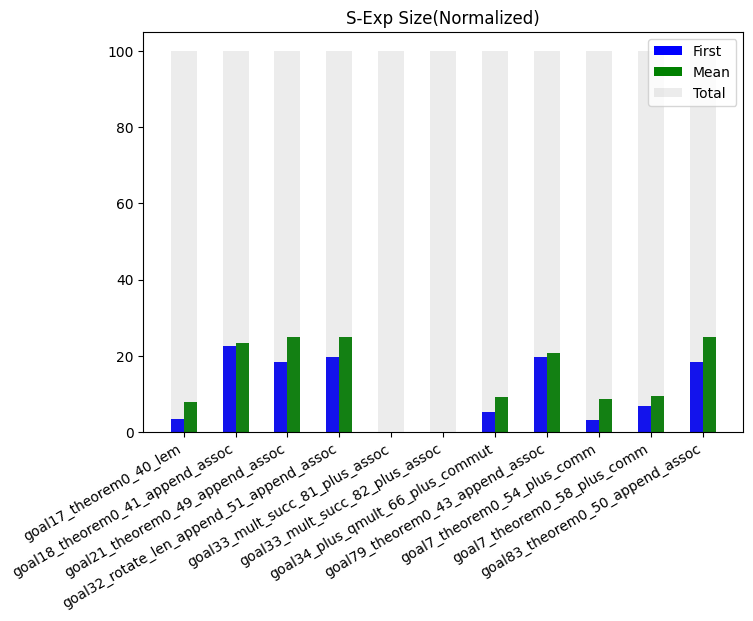

In [155]:
visualize_ranks("S-Exp Size", frames, f3, a3)

In [163]:
sed_f, sed_a = order_by_sed(frames)
ted_f, ted_a = order_by_ted(frames)

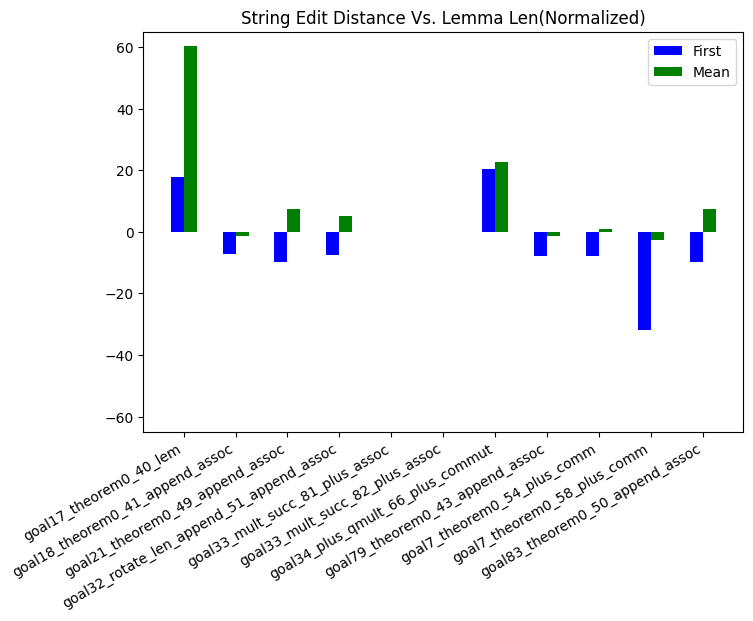

In [165]:
visualize_rank_difference("String Edit Distance Vs. Lemma Len", frames, sed_f, sed_a, a1, a2)

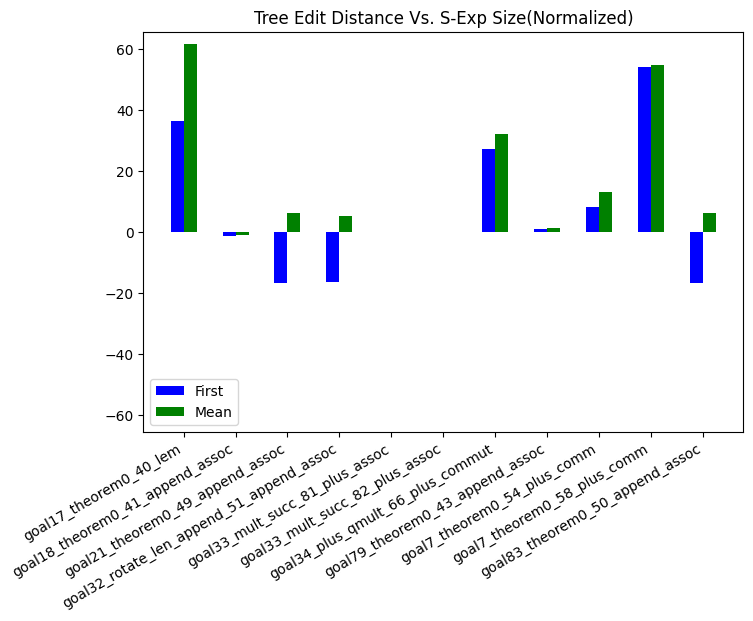

In [167]:
visualize_rank_difference("Tree Edit Distance Vs. S-Exp Size", frames, ted_f, ted_a, a3, a3)

In [138]:
ordered_frames = sorted(frames, key=lambda frame: frame.file[0])


In [140]:
for frame in ordered_frames:
  print(frame.file[0])

smallclam_lf_goal17_theorem0_40_lem
smallclam_lf_goal18_theorem0_41_append_assoc
smallclam_lf_goal21_theorem0_49_append_assoc
smallclam_lf_goal32_rotate_len_append_51_append_assoc
smallclam_lf_goal33_mult_succ_81_plus_assoc
smallclam_lf_goal33_mult_succ_82_plus_assoc
smallclam_lf_goal34_plus_qmult_66_plus_commut
smallclam_lf_goal79_theorem0_43_append_assoc
smallclam_lf_goal7_theorem0_54_plus_comm
smallclam_lf_goal7_theorem0_58_plus_comm
smallclam_lf_goal83_theorem0_50_append_assoc


In [161]:
frames = sorted(frames, key=lambda frame: frame.file[0])


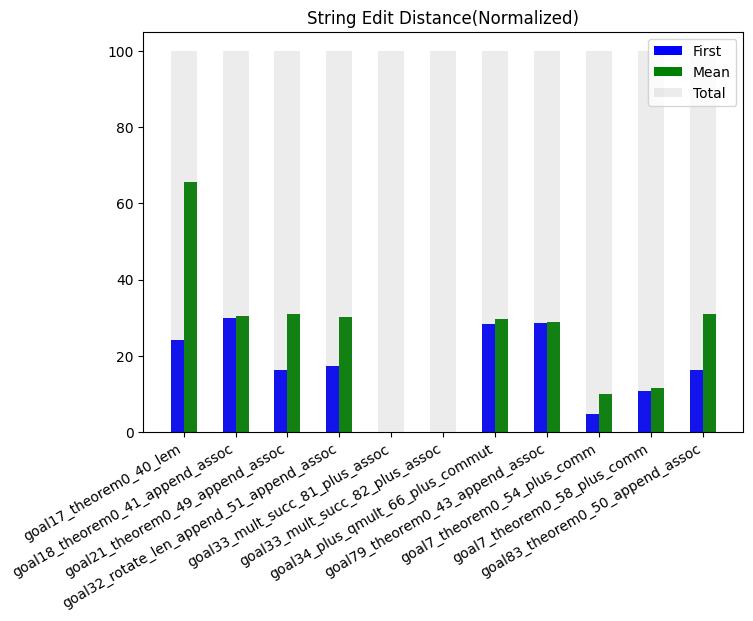

In [164]:
visualize_ranks("String Edit Distance", frames, sed_f, sed_a)

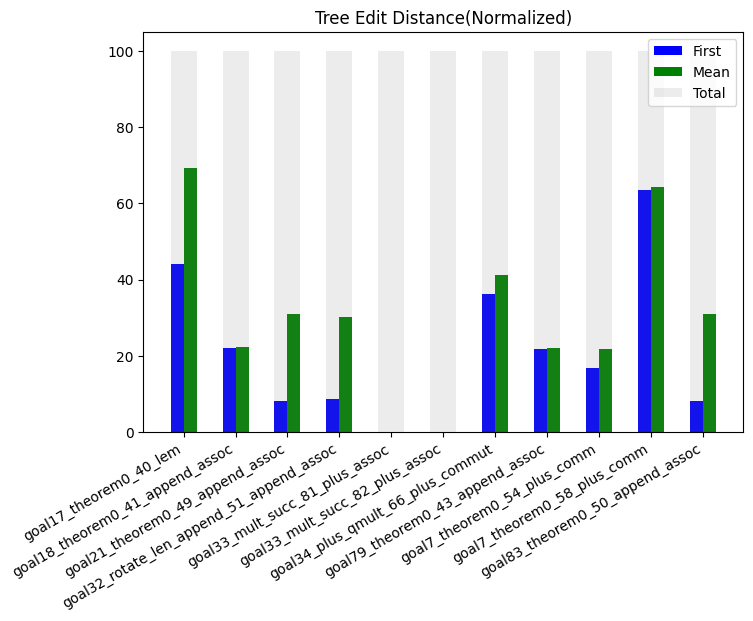

In [166]:
visualize_ranks("Tree Edit Distance", frames, ted_f, ted_a)
